In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import scipy.signal as signal_proc
from scipy.signal import butter, filtfilt, medfilt, resample_poly
import pandas as pd
from scipy.signal import find_peaks

def compute_fft_with_hann(signal, sampling_freq):
    """
    Compute FFT with Hann window for power spectral density estimation
    
    Parameters:
    - signal: input signal
    - sampling_freq: sampling frequency in Hz
    
    Returns:
    - freqs: frequency array
    - psd: power spectral density
    """
    # Apply Hann window
    windowed_signal = signal * np.hanning(len(signal))
    
    # Compute FFT
    fft_result = np.fft.fft(windowed_signal)
    
    # Calculate frequencies
    freqs = np.fft.fftfreq(len(signal), 1/sampling_freq)
    
    # Take only positive frequencies (one-sided spectrum)
    positive_freq_idx = freqs >= 0
    freqs = freqs[positive_freq_idx]
    fft_result = fft_result[positive_freq_idx]
    
    # Calculate power spectral density
    # Scale by 2 to account for negative frequencies (except DC and Nyquist)
    psd = np.abs(fft_result)**2 / (sampling_freq * len(signal))
    psd[1:-1] *= 2  # Scale all frequencies except DC and Nyquist
    
    # Correct for window power
    window_power = np.mean(np.hanning(len(signal))**2)
    psd /= window_power
    
    return freqs, psd

# Add project path
project_root = Path("..").resolve()
sys.path.append(str(project_root))

from ml_toolbox.data_loader import DataLoader, WindowConfig, WindowExtractor

# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

frequency = '30hz'
sensor_type = 'current'
load = 'no_load'

if sensor_type == 'current':
    sampling_rate = 10000 
    nperseg = 4096 
else:
    sampling_rate = 26041
    nperseg = 1024
    
xlim = sampling_rate / 2
# Load one sample for demo
healthy, healthy_metadata = data_loader.load_batch(
    condition='system_misalignment', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

# Load faulty data for comparison
faulty_data, faulty_metadata = data_loader.load_batch(
    condition='misalignment', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

n_healthy = healthy[0].shape[0] 
n_faulty = faulty_data[0].shape[0]

# Create windows
overlap_ratio = 0.5
healthy_step_size = int(n_healthy * (1 - overlap_ratio))
healthy_window_config = WindowConfig(window_size=n_healthy, 
                             step_size=healthy_step_size,
                             overlap_ratio=overlap_ratio)
healthy_extractor = WindowExtractor(healthy_window_config)
healthy_windows, healthy_win_metadata = healthy_extractor.extract_windows(healthy[0], healthy_metadata[0])

faulty_step_size = int(faulty_data[0].shape[0] * (1 - overlap_ratio))
faulty_window_config = WindowConfig(
    window_size=n_faulty,
    step_size=faulty_step_size,
    overlap_ratio=overlap_ratio
)

faulty_extractor = WindowExtractor(faulty_window_config)
faulty_windows, faulty_win_metadata = faulty_extractor.extract_windows(faulty_data[0], faulty_metadata[0])

print(f"Loaded faulty signal: {faulty_data[0].shape}")
print(f"Created {len(faulty_windows)} faulty windows")

print(f"Loaded healthy signal: {healthy[0].shape}")
print(f"Created {len(healthy_windows)} healthy windows")

h_w = healthy_windows[0]
h_ch1 = h_w[:, 0]
h_ch2 = h_w[:, 1]

f_w = faulty_windows[0]
f_ch1 = f_w[:, 0]
f_ch2 = f_w[:, 1]

# Apply Butter
cutoff = 600.0  # Hz, just above 500 Hz
b, a = butter(4, cutoff / (sampling_rate/2), btype='low', analog=False)
h_ch1 = filtfilt(b, a, h_ch1)
f_ch1 = filtfilt(b, a, h_ch2)

# decimate by 5 safely (resample_poly does anti-alias filtering too)
decim = 5
h_ch1 = resample_poly(h_ch1, up=1, down=decim)
f_ch1 = resample_poly(f_ch1, up=1, down=decim)
sampling_rate = sampling_rate / decim  # 2000 Hz

# Calculate PSD 
freqs_h_ch1, psd_h_ch1 = compute_fft_with_hann(h_ch1, sampling_freq=sampling_rate) #signal_proc.welch(h_ch1, fs=sampling_rate, nperseg=nperseg)
freqs_h_ch2, psd_h_ch2 = compute_fft_with_hann(h_ch2, sampling_freq=sampling_rate) #signal_proc.welch(h_ch2, fs=sampling_rate, nperseg=nperseg)
freqs_f_ch1, psd_f_ch1 = compute_fft_with_hann(f_ch1, sampling_freq=sampling_rate) #signal_proc.welch(f_ch1, fs=sampling_rate, nperseg=nperseg)
freqs_f_ch2, psd_f_ch2 = compute_fft_with_hann(f_ch2, sampling_freq=sampling_rate) #signal_proc.welch(f_ch2, fs=sampling_rate, nperseg=nperseg)

# Normalize PSD for peak tracking
psd_h_ch1 /= np.max(psd_h_ch1)
psd_h_ch2 /= np.max(psd_h_ch2)
psd_f_ch1 /= np.max(psd_f_ch1)
psd_f_ch2 /= np.max(psd_f_ch2)

#find peaks
noise_floor_h_ch1 = np.median(psd_h_ch1)
noise_floor_h_ch2 = np.median(psd_h_ch2)
noise_floor_f_ch1 = np.median(psd_f_ch1)
noise_floor_f_ch2 = np.median(psd_f_ch2)

peaks_h_ch1, _ = find_peaks(psd_h_ch1, 
                           height=np.percentile(psd_h_ch1, 95), 
                           prominence=noise_floor_h_ch1*4,
                           distance=5)
peaks_h_ch2, _ = find_peaks(psd_h_ch2, 
                           height=np.percentile(psd_h_ch2, 95),  
                           prominence=noise_floor_h_ch2*4,
                           distance=5)
peaks_f_ch1, _ = find_peaks(psd_f_ch1, 
                           height=np.percentile(psd_f_ch1, 95),   
                           prominence=noise_floor_f_ch1*4,
                           distance=5)
peaks_f_ch2, _ = find_peaks(psd_f_ch2, 
                           height=np.percentile(psd_f_ch2, 95),   
                           prominence=noise_floor_f_ch2*4,
                           distance=5)


INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files


Loaded faulty signal: (78199, 2)
Created 1 faulty windows
Loaded healthy signal: (165300, 2)
Created 1 healthy windows


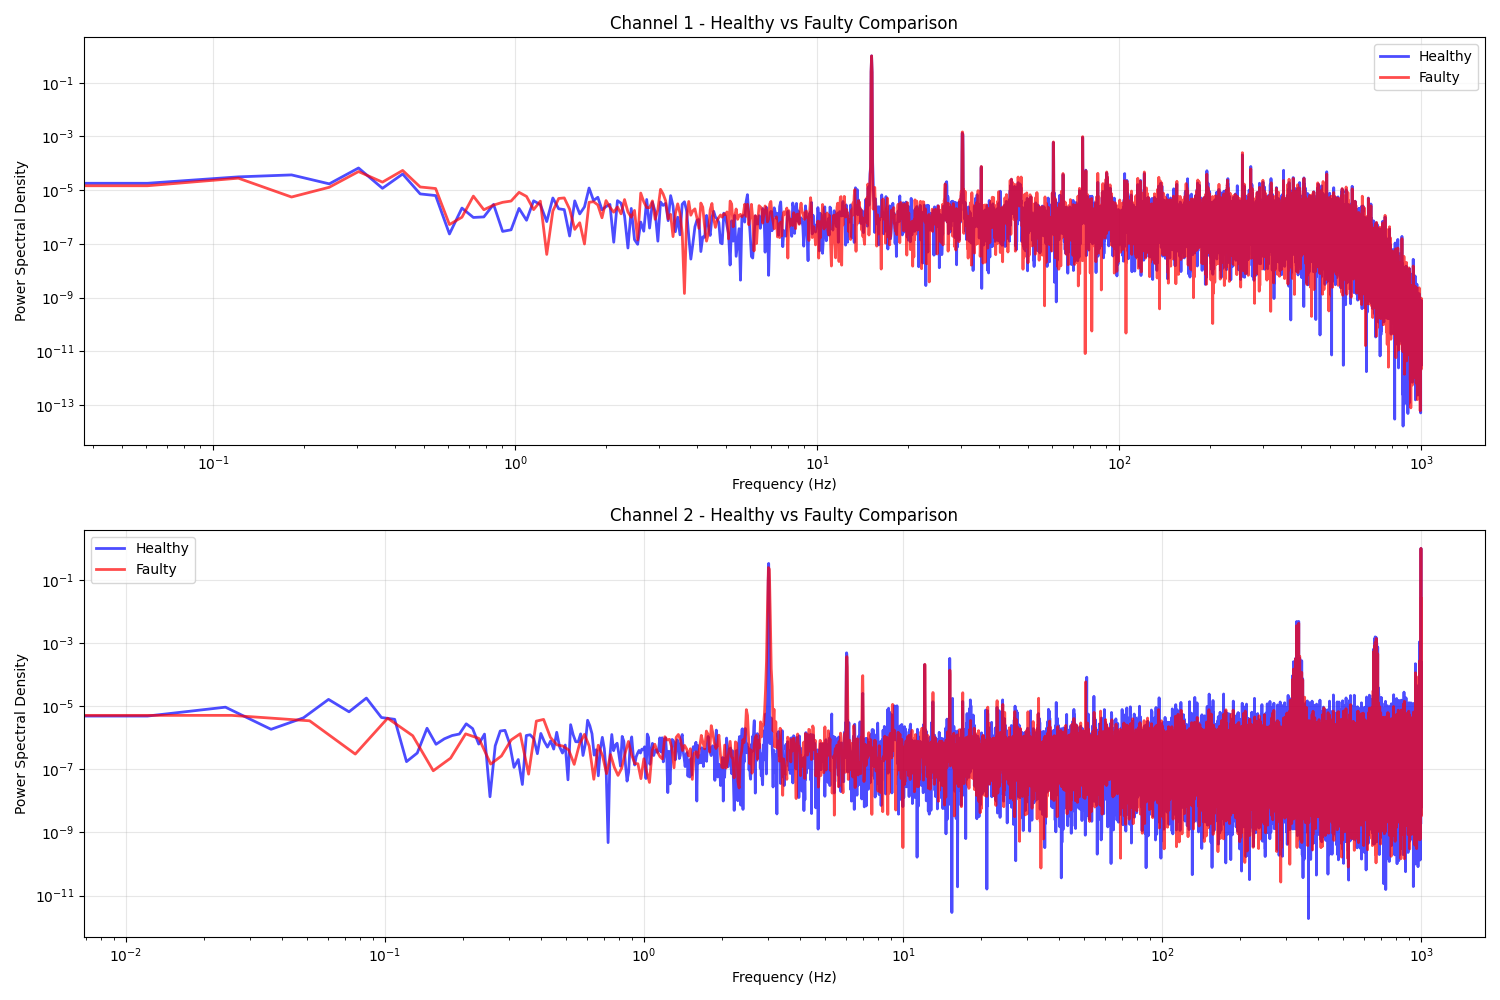

In [2]:
plt.ioff()  # Turn off interactive mode temporarily
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Channel 1 - Healthy vs Faulty
axes[0].loglog(freqs_h_ch1, psd_h_ch1, 'b-', alpha=0.7, label='Healthy', linewidth=2)
axes[0].loglog(freqs_f_ch1, psd_f_ch1, 'r-', alpha=0.7, label='Faulty', linewidth=2)
#axes[0].set_ylim(bottom=1e-9)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density')
axes[0].set_title('Channel 1 - Healthy vs Faulty Comparison')
axes[0].legend()

# Channel 2 - Healthy vs Faulty
axes[1].loglog(freqs_h_ch2, psd_h_ch2, 'b-', alpha=0.7, label='Healthy', linewidth=2)
axes[1].loglog(freqs_f_ch2, psd_f_ch2, 'r-', alpha=0.7, label='Faulty', linewidth=2)
#axes[1].set_ylim(bottom=1e-9)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power Spectral Density')
axes[1].set_title('Channel 2 - Healthy vs Faulty Comparison')
axes[1].legend()

plt.tight_layout()
plt.ion()  # Turn interactive mode back on
plt.show()

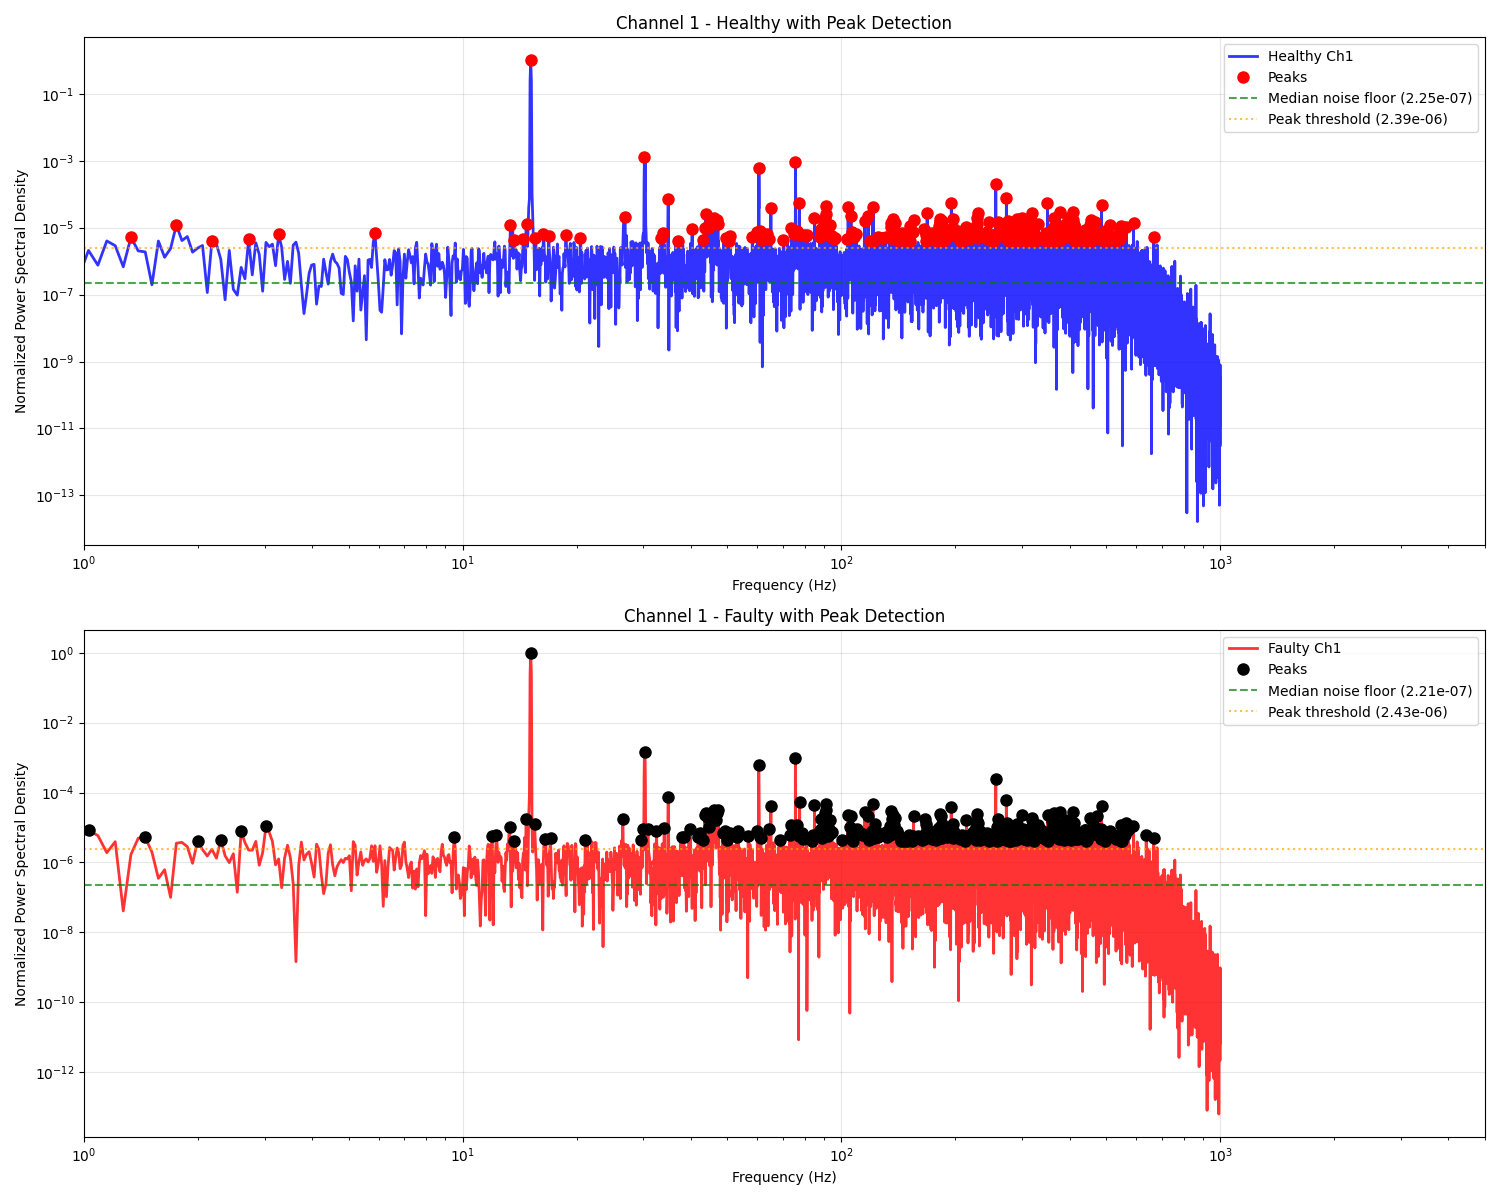

Number of peaks - Healthy: 334, Faulty: 349

Healthy Ch1 peak frequencies and amplitudes:
  Peak 1: 0.30 Hz, Amplitude: 6.68e-05
  Peak 2: 1.33 Hz, Amplitude: 5.11e-06
  Peak 3: 1.75 Hz, Amplitude: 1.20e-05
  Peak 4: 2.18 Hz, Amplitude: 4.06e-06
  Peak 5: 2.72 Hz, Amplitude: 4.49e-06
  Peak 6: 3.27 Hz, Amplitude: 6.25e-06
  Peak 7: 5.87 Hz, Amplitude: 6.81e-06
  Peak 8: 13.37 Hz, Amplitude: 1.23e-05
  Peak 9: 13.67 Hz, Amplitude: 4.40e-06
  Peak 10: 14.46 Hz, Amplitude: 4.47e-06
  Peak 11: 14.76 Hz, Amplitude: 1.32e-05
  Peak 12: 15.12 Hz, Amplitude: 1.00e+00
  Peak 13: 15.55 Hz, Amplitude: 4.87e-06
  Peak 14: 16.33 Hz, Amplitude: 6.67e-06
  Peak 15: 16.88 Hz, Amplitude: 5.77e-06
  Peak 16: 18.75 Hz, Amplitude: 6.12e-06
  Peak 17: 20.45 Hz, Amplitude: 4.94e-06
  Peak 18: 26.80 Hz, Amplitude: 2.07e-05
  Peak 19: 30.19 Hz, Amplitude: 1.33e-03
  Peak 20: 33.39 Hz, Amplitude: 4.94e-06
  Peak 21: 33.82 Hz, Amplitude: 6.81e-06
  Peak 22: 34.91 Hz, Amplitude: 7.40e-05
  Peak 23: 37.08 Hz, Amp

In [3]:
# Plot individual PSDs with peaks and median lines
plt.ioff()  # Turn off interactive mode temporarily
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Channel 1 - Healthy with peaks
axes[0].loglog(freqs_h_ch1, psd_h_ch1, 'b-', alpha=0.8, label='Healthy Ch1', linewidth=2)
# Mark peaks
axes[0].loglog(freqs_h_ch1[peaks_h_ch1], psd_h_ch1[peaks_h_ch1], 'ro', markersize=8, label='Peaks')
# Add median noise floor line
axes[0].axhline(y=noise_floor_h_ch1, color='g', linestyle='--', alpha=0.7, label=f'Median noise floor ({noise_floor_h_ch1:.2e})')
# Add threshold line (3x median)
axes[0].axhline(y=np.percentile(psd_h_ch1, 90), color='orange', linestyle=':', alpha=0.7, label=f'Peak threshold ({np.percentile(psd_h_ch1, 90):.2e})')
axes[0].set_xlim(1, xlim)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Normalized Power Spectral Density')
axes[0].set_title('Channel 1 - Healthy with Peak Detection')
axes[0].legend()

# Channel 1 - Faulty with peaks
axes[1].loglog(freqs_f_ch1, psd_f_ch1, 'r-', alpha=0.8, label='Faulty Ch1', linewidth=2)
# Mark peaks
axes[1].loglog(freqs_f_ch1[peaks_f_ch1], psd_f_ch1[peaks_f_ch1], 'ko', markersize=8, label='Peaks')
# Add median noise floor line
axes[1].axhline(y=noise_floor_f_ch1, color='g', linestyle='--', alpha=0.7, label=f'Median noise floor ({noise_floor_f_ch1:.2e})')
# Add threshold line (3x median)
axes[1].axhline(y=np.percentile(psd_f_ch1, 90), color='orange', linestyle=':', alpha=0.7, label=f'Peak threshold ({np.percentile(psd_f_ch1, 90):.2e})')
axes[1].set_xlim(1, xlim)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Normalized Power Spectral Density')
axes[1].set_title('Channel 1 - Faulty with Peak Detection')
axes[1].legend()

plt.tight_layout()
plt.ion()  # Turn interactive mode back on
plt.show()

# Print peak information
healthy_peak_freqs = freqs_h_ch1[peaks_h_ch1]
faulty_peak_freqs = freqs_f_ch1[peaks_f_ch1]

print(f"Number of peaks - Healthy: {len(peaks_h_ch1)}, Faulty: {len(peaks_f_ch1)}")

# Print individual peak frequencies and amplitudes for better readability
if len(healthy_peak_freqs) > 0:
    healthy_peak_amplitudes = psd_h_ch1[peaks_h_ch1]
    print("\nHealthy Ch1 peak frequencies and amplitudes:")
    for i, (freq, amp) in enumerate(zip(healthy_peak_freqs, healthy_peak_amplitudes)):
        print(f"  Peak {i+1}: {freq:.2f} Hz, Amplitude: {amp:.2e}")
else:
    print("\nNo peaks found in Healthy Ch1")

if len(faulty_peak_freqs) > 0:
    faulty_peak_amplitudes = psd_f_ch1[peaks_f_ch1]
    print("\nFaulty Ch1 peak frequencies and amplitudes:")
    for i, (freq, amp) in enumerate(zip(faulty_peak_freqs, faulty_peak_amplitudes)):
        print(f"  Peak {i+1}: {freq:.2f} Hz, Amplitude: {amp:.2e}")
else:
    print("\nNo peaks found in Faulty Ch1")

# Compare peak amplitudes
if len(healthy_peak_freqs) > 0 and len(faulty_peak_freqs) > 0:
    print(f"\nPeak amplitude comparison:")
    print(f"  Healthy - Max amplitude: {np.max(healthy_peak_amplitudes):.2e}")
    print(f"  Healthy - Mean amplitude: {np.mean(healthy_peak_amplitudes):.2e}")
    print(f"  Faulty - Max amplitude: {np.max(faulty_peak_amplitudes):.2e}")
    print(f"  Faulty - Mean amplitude: {np.mean(faulty_peak_amplitudes):.2e}")
    
    ratio = np.mean(faulty_peak_amplitudes) / np.mean(healthy_peak_amplitudes)
    print(f"  Faulty/Healthy amplitude ratio: {ratio:.2f}")
    if ratio > 1.5:
        print("Faulty condition shows significantly higher peak amplitudes")
    elif ratio < 0.67:
        print("Faulty condition shows significantly lower peak amplitudes")
    else:
        print("Similar peak amplitudes between conditions")